In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from alpha_vantage.techindicators import TechIndicators
from utils import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score as sk_f1_score
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, Dropout, MaxPooling1D, Activation, GlobalMaxPooling1D, Input, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

np.random.seed(1)

#### Obtain price data and technical indicators

<span style="color:red">Don't run if data is already available.</span>

<AxesSubplot:xlabel='Date'>

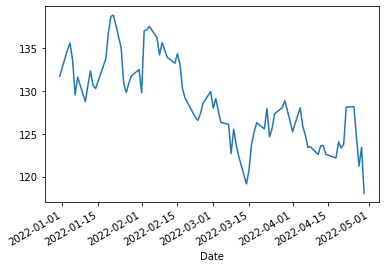

In [21]:
start_date = datetime.datetime(2022, 1, 1)
end_date = datetime.datetime(2022, 4, 30)

ticker = "EA"

history = yf.Ticker(ticker).history(start=start_date, end=end_date)
history["Close"].plot()

In [22]:
intervals = np.arange(6, 21)

In [ ]:
sma = get_sma(ticker, intervals, start_date, end_date)
ema = get_ema(ticker, intervals, start_date, end_date)

In [24]:
wma = get_wma(ticker, intervals, start_date, end_date)
t3 = get_t3(ticker, intervals, start_date, end_date)
rsi = get_rsi(ticker, intervals, start_date, end_date)
willr = get_willr(ticker, intervals, start_date, end_date)
adx = get_adx(ticker, intervals, start_date, end_date)
mom = get_mom(ticker, intervals, start_date, end_date)
cci = get_cci(ticker, intervals, start_date, end_date)
cmo = get_cmo(ticker, intervals, start_date, end_date)
roc = get_roc(ticker, intervals, start_date, end_date)
mfi = get_mfi(ticker, intervals, start_date, end_date)
trix = get_trix(ticker, intervals, start_date, end_date)
dx = get_dx(ticker, intervals, start_date, end_date)
trima = get_trima(ticker, intervals, start_date, end_date)

--- Obtaining WMA ---
--- Obtaining T3 ---
--- Obtaining RSI ---
--- Obtaining WILLR ---
--- Obtaining ADX ---
--- Obtaining MOM ---
--- Obtaining CCI ---
--- Obtaining CMO ---
--- Obtaining ROC ---
--- Obtaining MFI ---
--- Obtaining TRIX ---
--- Obtaining DX ---
--- Obtaining TRIMA ---


In [26]:
df = pd.concat([history, ema, sma, wma, trima, t3, rsi, willr, adx, mom, cci, cmo, roc, mfi, trix, dx], axis=1)
df = df.dropna()
df = df.drop(["Open", "High", "Low", "Volume", "Dividends", "Stock Splits"], axis=1)
df = df.rename(columns={"Close": "close"})
df.to_csv("EA_new.csv", index_label="date")

#### Read data and create labels

In [6]:
df = pd.read_csv("EA_15.csv")
df = df.set_index("date")
df.index = pd.to_datetime(df.index)
df

,close,ema_6,ema_7,ema_8,ema_9,ema_10,ema_11,ema_12,ema_13,ema_14,...,dx_11,dx_12,dx_13,dx_14,dx_15,dx_16,dx_17,dx_18,dx_19,dx_20
date,,,,,,,,,,,,,,,,,,,,,
2002-01-02,29.831154,29.8857,29.9079,29.9311,29.9523,29.9695,29.9815,29.9879,29.9887,29.9841,...,21.5320,21.6341,21.6598,21.6090,21.4878,21.3045,21.0685,20.7886,20.4732,20.1298
2002-01-03,30.257881,29.9919,29.9952,30.0036,30.0133,30.0218,30.0275,30.0293,30.0270,30.0205,...,28.3483,27.7211,27.1564,26.6202,26.0943,25.5694,25.0414,24.5095,23.9745,23.4381
2002-01-04,31.240339,30.3484,30.3064,30.2783,30.2586,30.2432,30.2295,30.2156,30.2003,30.1831,...,41.5495,39.7818,38.2503,36.8896,35.6552,34.5166,33.4532,32.4507,31.4990,30.5911
2002-01-07,29.478857,30.0998,30.0993,30.1005,30.1025,30.1042,30.1043,30.1021,30.0971,30.0891,...,17.9832,18.5187,18.9138,19.1858,19.3510,19.4245,19.4197,19.3490,19.2232,19.0518
2002-01-08,29.076939,29.8074,29.8436,29.8729,29.8973,29.9173,29.9330,29.9443,29.9513,29.9541,...,8.6640,9.9726,11.0351,11.8882,12.5631,13.0867,13.4821,13.7690,13.9643,14.0826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,132.860870,131.1931,130.8829,130.6026,130.3558,130.1444,129.9682,129.8259,129.7150,129.6328,...,28.9088,24.8694,21.4667,18.5915,16.1511,14.0694,12.2845,10.7461,9.4134,8.2536
2021-12-28,133.290298,131.7908,131.4835,131.1987,130.9417,130.7155,130.5211,130.3581,130.2250,130.1198,...,35.9271,31.4567,27.6420,24.3822,21.5879,19.1830,17.1039,15.2983,13.7230,12.3424
2021-12-29,132.960739,132.1237,131.8516,131.5892,131.3445,131.1228,130.9269,130.7577,130.6151,130.4980,...,23.2554,20.5414,18.1163,15.9716,14.0844,12.4269,10.9708,9.6902,8.5618,7.5652


In [7]:
df.describe()

,close,ema_6,ema_7,ema_8,ema_9,ema_10,ema_11,ema_12,ema_13,ema_14,...,dx_11,dx_12,dx_13,dx_14,dx_15,dx_16,dx_17,dx_18,dx_19,dx_20
count,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000,...,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000
mean,57.841513,57.788872,57.778811,57.768801,57.758834,57.748901,57.738988,57.729091,57.719197,57.709299,...,26.520804,25.429902,24.466555,23.603411,22.830420,22.129612,21.491481,20.914750,20.381940,19.887206
std,38.012829,37.950243,37.939090,37.928089,37.917207,37.906418,37.895694,37.885017,37.874367,37.863727,...,18.218356,17.618351,17.083590,16.608055,16.171689,15.773381,15.405579,15.053458,14.727894,14.425891
min,10.866638,11.197500,11.232900,11.265200,11.295200,11.323400,11.350300,11.376400,11.401900,11.426800,...,0.027300,0.001300,0.021100,0.003300,0.005000,0.000600,0.000700,0.007200,0.001000,0.007300
25%,24.691830,24.747325,24.764825,24.804150,24.838150,24.863225,24.906775,24.937575,24.959425,24.985900,...,11.444900,10.720175,10.152700,9.798775,9.514750,9.305900,9.043875,8.656475,8.406475,8.196300
50%,49.659046,49.726050,49.721100,49.710200,49.738600,49.716450,49.725550,49.737550,49.756000,49.752850,...,23.546950,22.324550,21.349600,20.510300,19.611800,18.950300,18.329200,17.699450,17.184350,16.731000
75%,81.236795,81.419675,81.412050,81.319950,81.296925,81.266775,81.227475,81.213950,81.130375,81.084375,...,39.058350,37.756375,36.271125,34.981100,34.038175,33.062975,32.020300,31.157900,30.304925,29.484800
max,148.032883,146.603000,146.383400,146.201400,146.016600,145.827200,145.636000,145.444500,145.280200,145.113000,...,88.786300,87.838300,86.904700,85.983400,85.073000,84.172300,83.280300,82.396200,81.519400,80.649400


<AxesSubplot:title={'center':'EA Close Price'}, xlabel='Year', ylabel='Close Price (USD)'>

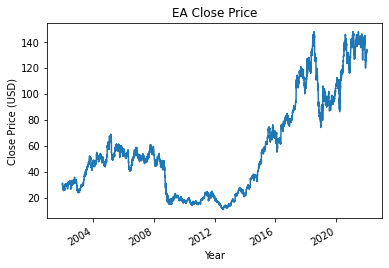

In [8]:
### Plot close price

df["close"].plot(title="EA Close Price", xlabel="Year", ylabel="Close Price (USD)")

In [9]:
# Create labels as per algorithm

WIN_SIZE = 3

labels = create_labels(df, window_size=WIN_SIZE)
df["labels"] = labels.astype(int)
df

--- Creating labels ---


5036it [00:01, 3497.23it/s]


,close,ema_6,ema_7,ema_8,ema_9,ema_10,ema_11,ema_12,ema_13,ema_14,...,dx_12,dx_13,dx_14,dx_15,dx_16,dx_17,dx_18,dx_19,dx_20,labels
date,,,,,,,,,,,,,,,,,,,,,
2002-01-02,29.831154,29.8857,29.9079,29.9311,29.9523,29.9695,29.9815,29.9879,29.9887,29.9841,...,21.6341,21.6598,21.6090,21.4878,21.3045,21.0685,20.7886,20.4732,20.1298,0
2002-01-03,30.257881,29.9919,29.9952,30.0036,30.0133,30.0218,30.0275,30.0293,30.0270,30.0205,...,27.7211,27.1564,26.6202,26.0943,25.5694,25.0414,24.5095,23.9745,23.4381,2
2002-01-04,31.240339,30.3484,30.3064,30.2783,30.2586,30.2432,30.2295,30.2156,30.2003,30.1831,...,39.7818,38.2503,36.8896,35.6552,34.5166,33.4532,32.4507,31.4990,30.5911,0
2002-01-07,29.478857,30.0998,30.0993,30.1005,30.1025,30.1042,30.1043,30.1021,30.0971,30.0891,...,18.5187,18.9138,19.1858,19.3510,19.4245,19.4197,19.3490,19.2232,19.0518,2
2002-01-08,29.076939,29.8074,29.8436,29.8729,29.8973,29.9173,29.9330,29.9443,29.9513,29.9541,...,9.9726,11.0351,11.8882,12.5631,13.0867,13.4821,13.7690,13.9643,14.0826,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,132.860870,131.1931,130.8829,130.6026,130.3558,130.1444,129.9682,129.8259,129.7150,129.6328,...,24.8694,21.4667,18.5915,16.1511,14.0694,12.2845,10.7461,9.4134,8.2536,2
2021-12-28,133.290298,131.7908,131.4835,131.1987,130.9417,130.7155,130.5211,130.3581,130.2250,130.1198,...,31.4567,27.6420,24.3822,21.5879,19.1830,17.1039,15.2983,13.7230,12.3424,0
2021-12-29,132.960739,132.1237,131.8516,131.5892,131.3445,131.1228,130.9269,130.7577,130.6151,130.4980,...,20.5414,18.1163,15.9716,14.0844,12.4269,10.9708,9.6902,8.5618,7.5652,1


In [10]:
# Counts of each label

print(f"Sell {sum(labels == 0)}")
print(f"Buy {sum(labels == 1)}")
print(f"Hold {sum(labels == 2)}")

Sell 1298
Buy 1295
Hold 2443


In [11]:
num_features = len(df.columns) - 1
shape = (int(np.sqrt(num_features)), int(np.sqrt(num_features)))

In [12]:
### Normalize data

minmax = MinMaxScaler(feature_range=(0, 1))

x = np.array(df.loc[:, "ema_6":"dx_20"])
x_norm = minmax.fit_transform(x)
x_reshaped = reshape_data(x_norm, shape[0], shape[1])

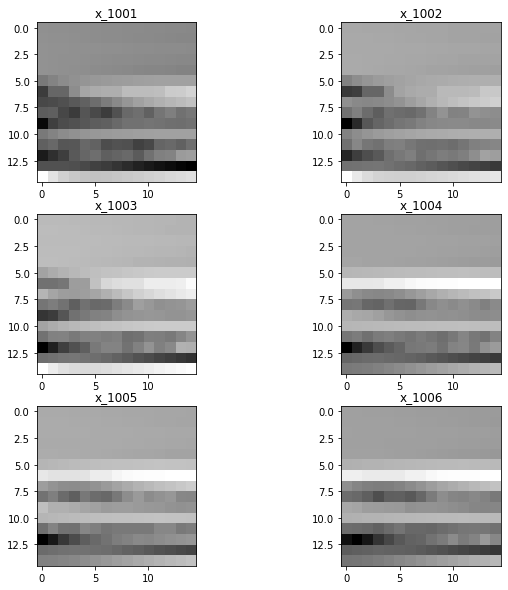

In [13]:
### Show data as images

w = 10
h = 10

fig = plt.figure(figsize=(w, h))
for i in range(1, 7):
    fig.add_subplot(3, 2, i)
    img = x_reshaped[i+1000]
    plt.title(f"x_{i+1000}")
    plt.imshow(img, cmap="binary")

plt.show()

#### Split data into training and testing sets

In [14]:
### Split data into train and test sets

start_year = 2002
end_year = 2021

train_data = []
test_data = []

for i in range(start_year, end_year-4):
    df_train = pd.concat([df[df.index.year == i+j] for j in range(4)])
    df_test = df[df.index.year == i+4]

    train_data.append(df_train)
    test_data.append(df_test)

In [15]:
### Prepare train and test data for model

x_train, y_train = [], []
x_test, y_test = [], []

temp = []

for i in range(len(train_data)):
    minmax = MinMaxScaler(feature_range=(0, 1))

    x = np.array(train_data[i].loc[:, "ema_6":"dx_20"])
    _x_norm = minmax.fit_transform(x)
    _x_reshaped = reshape_data(_x_norm, shape[0], shape[1])

    y = np.array(train_data[i].loc[:, "labels"])
    y_cat = to_categorical(y)

    temp = np.concatenate((temp, y), axis=None)
    x_train.append(_x_reshaped)
    y_train.append(y_cat)

for i in range(len(test_data)):
    minmax = MinMaxScaler(feature_range=(0, 1))
    
    x = np.array(test_data[i].loc[:, "ema_6":"dx_20"])
    _x_norm = minmax.fit_transform(x)
    _x_reshaped = reshape_data(_x_norm, shape[0], shape[1])

    y = np.array(test_data[i].loc[:, "labels"])
    y_cat = to_categorical(y)

    x_test.append(_x_reshaped)
    y_test.append(y_cat)

sample_weights = get_sample_weights(temp)

Class weights [1.30153395 1.30086133 0.68354831]
Value counts: (array([0, 1, 2]), array([3868, 3870, 7365]))


#### Create and train model

In [67]:
### CNN model architecture

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=(15,15,1)))
model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.50))
model.add(Dense(3, activation="softmax"))

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 15, 15, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 15, 15, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 7, 7, 64)          0         
                                                                 
 flatten_6 (Flatten)         (None, 3136)              0         
                                                                 
 dense_12 (Dense)            (None, 64)                200768    
                                                      

7/7 [==============================] - 0s 66ms/step - loss: 0.9378 - accuracy: 0.4988 - f1_score: 0.3450 - val_loss: 0.9677 - val_accuracy: 0.4703 - val_f1_score: 0.2009 - lr: 0.0010


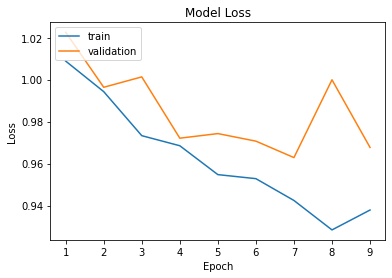

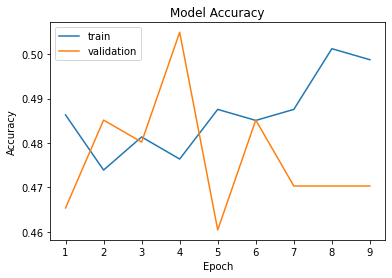

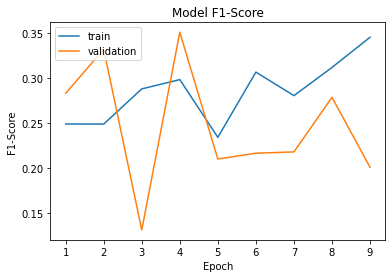

In [68]:
### Train model

EPOCHS = 9
BATCH_SIZE = 128

optimizer = Adam(learning_rate=0.0005)

model.compile(loss="categorical_crossentropy", metrics=["accuracy", f1_score])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                   patience=100, min_delta=0.0001)
rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.02, patience=10, verbose=1, mode='min',
                        min_delta=0.001, cooldown=1, min_lr=0.0001)
mcp = ModelCheckpoint("best_model", monitor='val_loss', verbose=0,
                      save_best_only=True, save_weights_only=False, mode='min', period=1)

train_history = {"loss":[],
                 "accuracy":[],
                 "f1_score":[],
                 "val_loss":[],
                 "val_accuracy":[],
                 "val_f1_score":[]}

for epoch in range(EPOCHS):
    for i in range(len(x_train)):
        hist = model.fit(x_train[i], y_train[i], validation_split=0.2, 
                         sample_weight=sample_weights, callbacks=[es, rlp, mcp],
                         batch_size=BATCH_SIZE, epochs=1)

    train_history["loss"] += hist.history["loss"]
    train_history["accuracy"] += hist.history["accuracy"]
    train_history["f1_score"] += hist.history["f1_score"]
    train_history["val_loss"] += hist.history["val_loss"]
    train_history["val_accuracy"] += hist.history["val_accuracy"]
    train_history["val_f1_score"] += hist.history["val_f1_score"]

plot_history(train_history)

#### Evaluate model with test data

In [69]:
### Predict test data with model

y_preds, y_true = np.array([]), np.array([])

for i, j in zip(x_test, y_test):
    _pred = model.predict(i)
    _y_pred = np.argmax(_pred, axis=1)
    y_preds = np.concatenate((y_preds, _y_pred), axis=None)

    _y_true = np.argmax(j, axis=1)
    y_true = np.concatenate((y_true, _y_true), axis=None)

In [70]:
print("Sell Buy Hold")
print(f"{confusion_matrix(y_true, y_preds)}")
print(f"Precision {precision_score(y_true, y_preds, average=None)}")
print(f"Recall {recall_score(y_true, y_preds, average=None)}")
print(f"F1 Score {sk_f1_score(y_true, y_preds, average=None)}")
print(f"Accuracy {accuracy_score(y_true, y_preds)}")

Sell Buy Hold
[[ 117   32  828]
 [   8  364  603]
 [ 103  317 1404]]
Precision [0.51315789 0.51051893 0.4952381 ]
Recall [0.11975435 0.37333333 0.76973684]
F1 Score [0.19419087 0.43127962 0.60270444]
Accuracy 0.4992055084745763


#### Prediction for new data

In [71]:
df_eval = pd.read_csv("EA_new.csv")
df_eval = df_eval.set_index("date")
df_eval.index = pd.to_datetime(df_eval.index)
df_eval

,close,ema_6,ema_7,ema_8,ema_9,ema_10,ema_11,ema_12,ema_13,ema_14,...,dx_11,dx_12,dx_13,dx_14,dx_15,dx_16,dx_17,dx_18,dx_19,dx_20
date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,134.768295,133.1084,132.8950,132.6776,132.4629,132.2567,132.0635,131.8862,131.7267,131.5857,...,18.5320,16.9989,15.4939,14.0638,12.7315,11.5056,10.3862,9.3691,8.4474,7.6132
2022-01-04,135.577209,133.8123,133.5643,133.3208,133.0847,132.8595,132.6482,132.4533,132.2761,132.1173,...,20.6258,18.9134,17.2566,15.6957,14.2496,12.9238,11.7160,10.6202,9.6280,8.7305
2022-01-05,133.619858,133.7559,133.5769,133.3862,133.1908,132.9968,132.8093,132.6320,132.4673,132.3169,...,28.0907,25.7719,23.5959,21.5842,19.7425,18.0667,16.5474,15.1728,13.9300,12.8064
2022-01-06,129.515381,132.5429,132.5603,132.5249,132.4547,132.3630,132.2595,132.1517,132.0449,131.9427,...,6.5483,5.4777,4.7344,4.2277,3.8912,3.6761,3.5471,3.4787,3.4523,3.4545
2022-01-07,131.602570,132.2728,132.3196,132.3188,132.2833,132.2238,132.1492,132.0665,131.9810,131.8967,...,18.8229,16.9238,15.4114,14.1990,13.2194,12.4208,11.7635,11.2170,10.7578,10.3678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,128.149994,125.7529,125.5328,125.3717,125.2545,125.1700,125.1101,125.0689,125.0422,125.0271,...,11.2384,8.9309,7.0479,5.5023,4.2281,3.1745,2.3011,1.5757,0.9722,0.4694
2022-04-26,124.629997,125.4321,125.3071,125.2069,125.1296,125.0718,125.0301,125.0014,124.9833,124.9741,...,2.2905,0.9957,0.0604,0.9206,1.6190,2.1836,2.6372,2.9991,3.2852,3.5087
2022-04-27,121.220001,124.2286,124.2853,124.3209,124.3477,124.3715,124.3951,124.4196,124.4457,124.4736,...,24.3604,23.2816,22.3139,21.4322,20.6187,19.8609,19.1499,18.4795,17.8452,17.2437


<AxesSubplot:title={'center':'EA Close Price'}, xlabel='Year', ylabel='Close Price (USD)'>

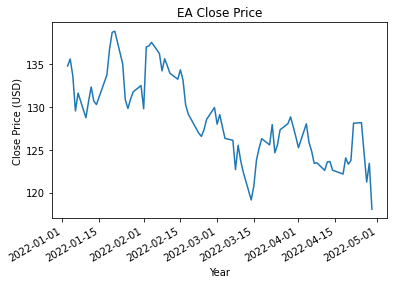

In [72]:
### Plot close price

df_eval["close"].plot(title="EA Close Price", xlabel="Year", ylabel="Close Price (USD)")

In [73]:
### Create labels as per algorithm

labels = create_labels(df_eval, window_size=WIN_SIZE)
df_eval["labels"] = labels.astype(int)

# Counts of each label

print(f"Sell {sum(labels == 0)}")
print(f"Buy {sum(labels == 1)}")
print(f"Hold {sum(labels == 2)}")

--- Creating labels ---


82it [00:00, 3412.68it/s]

Sell 22
Buy 19
Hold 41


In [74]:
### Reshape new data

minmax = MinMaxScaler(feature_range=(0, 1))
    
x = np.array(df_eval.loc[:, "ema_6":"dx_20"])
_x_norm = minmax.fit_transform(x)
_x_reshaped = reshape_data(_x_norm, shape[0], shape[1])

y = np.array(df_eval.loc[:, "labels"])
y_cat = to_categorical(y)

x_new = _x_reshaped
y_new = y_cat

In [75]:
abc = model.predict(x_new)
np.argmax(abc, axis=1)

array([2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 0, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 1, 1, 2, 2, 0, 0, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2,
       1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1])

In [76]:
model.evaluate(x_new, y_new)

3/3 [==============================] - 0s 4ms/step - loss: 0.9408 - accuracy: 0.5244 - f1_score: 0.4337


[0.9408376812934875, 0.5243902206420898, 0.43368029594421387]